In [1]:
# -*- coding: utf-8 -*-

"""Script that trains the decision tree. Set WRITE to True in order to
generate csv files of preprocessed data.
Set SUBMIT to True to generate the submission file post training"""

import re
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from utils import preprocess_data
warnings.filterwarnings("ignore")

In [15]:
WRITE = True
SUBMIT = False
PATH_DATA = "data/"
PATH_PREPRO = PATH_DATA + "preprocessing/"

train = pd.read_csv(PATH_DATA + "train.csv")
submission = pd.read_csv(PATH_DATA + "sample_submission.csv")


train_set = pd.read_csv("./data/preprocessing/train_set.csv")
test_set = pd.read_csv("./data/preprocessing/test_set.csv")

train_set = pd.merge(train_set, train, on='segment_id')
train_set = train_set.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
test_set = test_set.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))



[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.6191142906653122. Current value: feature_fraction=0.6191142906653122
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=21. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_data_in_leaf is set=69, min_data=21 will be ignored. Current value: min_data_in_leaf=69
Simple LGB model rmse: 3625366


FileNotFoundError: [Errno 2] No such file or directory: '../data/lgbm_importances-01.png'

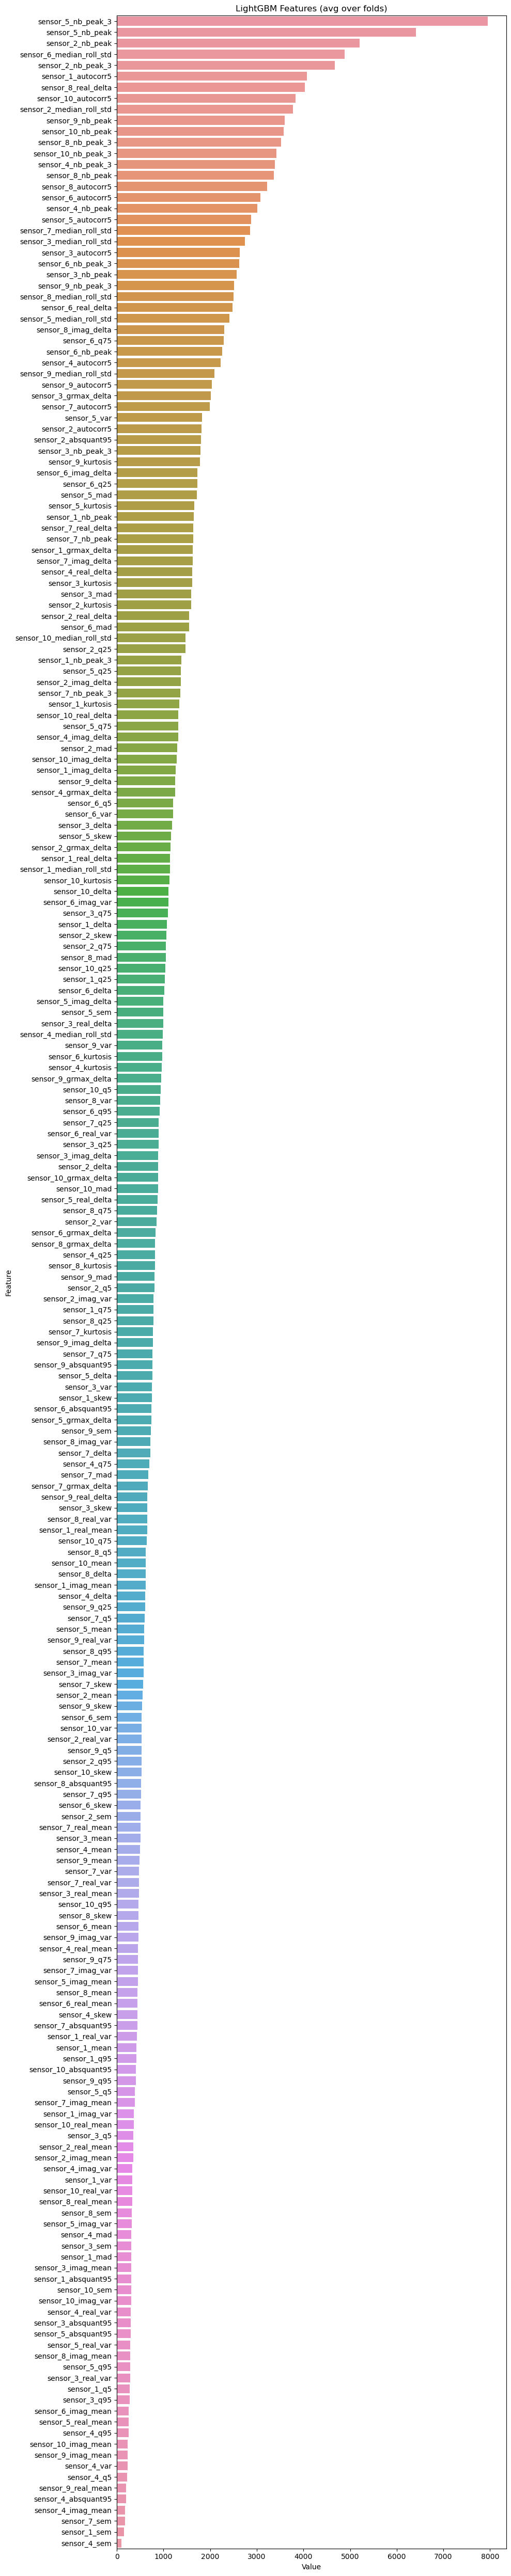

In [16]:
# Training (opt 2.604.528)
params = {'learning_rate': 0.2685684371804056, 'boosting_type': 'dart',
          'objective': 'regression', 'metric': 'mae',
          'sub_feature': 0.6191142906653122, 'num_leaves': 408,
          'min_data': 21, 'max_depth': 132, 'max_bin': 2693,
          'min_data_in_leaf': 69, 'n_estimators': 3232,
          "num_iterations": 7000}

model = LGBMRegressor(**params)

train = train_set.drop(['segment_id', 'time_to_eruption'], axis=1)
y = train_set['time_to_eruption']

if not SUBMIT:
    train, val, y, y_val = train_test_split(train, y,
                                            random_state=42,
                                            test_size=0.2)
    model.fit(train, y)
    preds = model.predict(val)
    print(f'Simple LGB model rmse: {mse(y_val, preds, squared=False):.0f}')
    # mse but in better format
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,
                                          train.columns)),
                               columns=['Value', 'Feature'])
    plt.figure(figsize=(10, 50))
    sns.barplot(x="Value", y="Feature",
                data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


else:
    model.fit(train, y)
    segments = test_set.segment_id
    test_set = test_set[train.columns]
    preds = model.predict(test_set)
    test_set["time_to_eruption"] = preds
    test_set = pd.concat([segments, test_set], axis=1)
    submission = pd.merge(submission,
                          test_set[['segment_id', 'time_to_eruption']],
                          on='segment_id')
    submission.drop(['time_to_eruption_x'], axis=1, inplace=True)
    submission.columns = ['segment_id', 'time_to_eruption']
    submission.to_csv('../data/submission.csv', index=False)
